In [ ]:
!pip install hurst


In [ ]:
!pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from hurst import compute_Hc
import numpy as np

In [ ]:

# Download S&P 500 data
sp500 = yf.download("^GSPC", start="2000-01-01", end="2025-01-01")

# Save to CSV
sp500.to_csv("sp500_data.csv")

print("S&P 500 data saved to sp500_data.csv")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

S&P 500 data saved to sp500_data.csv


In [ ]:


# Load the saved dataset
sp500 = pd.read_csv("sp500_data.csv", index_col="Date", parse_dates=True)

# Ensure no missing values
sp500.dropna(inplace=True)

# Compute Log Returns
sp500["Log_Returns"] = np.log(sp500["Close"] / sp500["Close"].shift(1))

# Drop NA values created by the shift
sp500.dropna(inplace=True)

# Save updated dataset
sp500.to_csv("sp500_with_returns.csv")

print("Log returns calculated and saved to sp500_with_returns.csv")


Log returns calculated and saved to sp500_with_returns.csv


In [ ]:
sp500=pd.read_csv("sp500_with_returns.csv")

In [ ]:
# Ensure 'Date' column is in datetime format (if not already)
sp500["Date"] = pd.to_datetime(sp500["Date"], format="%d-%m-%Y")

sp500 = sp500.set_index("Date") #Set Date as index

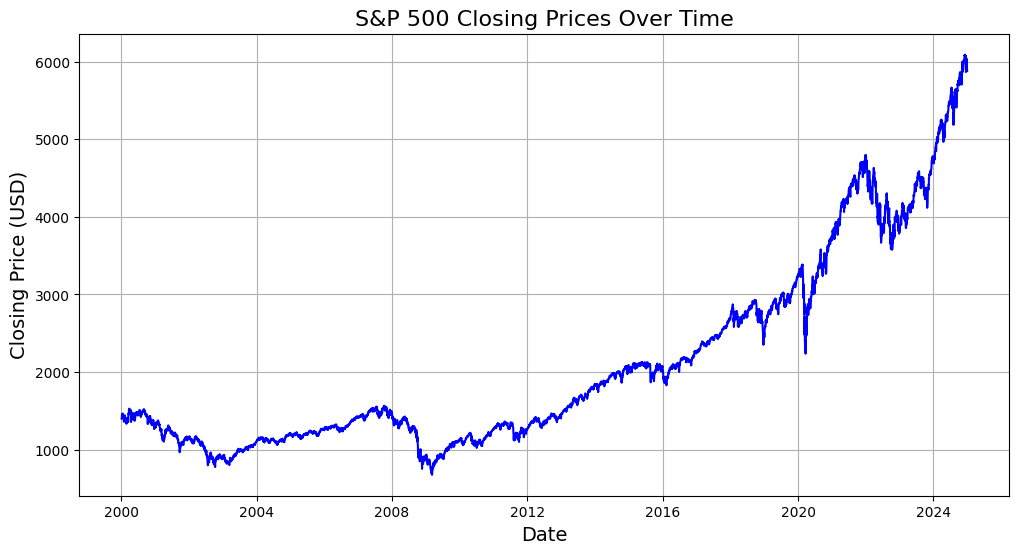

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is already loaded in 'sp500' DataFrame
# and it has a 'Close' column and a DateTime index

# Plotting the S&P 500 Closing Prices
plt.figure(figsize=(12, 6))
plt.plot(sp500.index, sp500['Close'], color='blue', linewidth=1.5)
plt.title('S&P 500 Closing Prices Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price (USD)', fontsize=14)
plt.grid(True)
plt.show()


In [ ]:
print(sp500.head())
print(sp500[["Close", "Log_Returns"]].describe())


                  Close         High          Low         Open      Volume  \
Date                                                                         
2000-01-04  1399.420044  1455.219971  1397.430054  1455.219971  1009000000   
2000-01-05  1402.109985  1413.270020  1377.680054  1399.420044  1085500000   
2000-01-06  1403.449951  1411.900024  1392.099976  1402.109985  1092300000   
2000-01-07  1441.469971  1441.469971  1400.729980  1403.449951  1225200000   
2000-01-10  1457.599976  1464.359985  1441.469971  1441.469971  1064800000   

            Log_Returns  
Date                     
2000-01-04    -0.039099  
2000-01-05     0.001920  
2000-01-06     0.000955  
2000-01-07     0.026730  
2000-01-10     0.011128  
             Close  Log_Returns
count  6288.000000  6288.000000
mean   2112.118645     0.000222
std    1243.384589     0.012234
min     676.530029    -0.127652
25%    1200.802460    -0.004805
50%    1491.640015     0.000600
75%    2749.067444     0.005900
max    6090.270

In [ ]:
# 4️⃣ **Check Stationarity using ADF Test**
def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("✅ Data is stationary (reject null hypothesis)")
    else:
        print("⚠️ Data is NOT stationary (consider differencing)")

print("\n📌 ADF Test for Log Returns:")
adf_test(sp500["Log_Returns"])


📌 ADF Test for Log Returns:
ADF Statistic: -19.098784358327226
p-value: 0.0
✅ Data is stationary (reject null hypothesis)


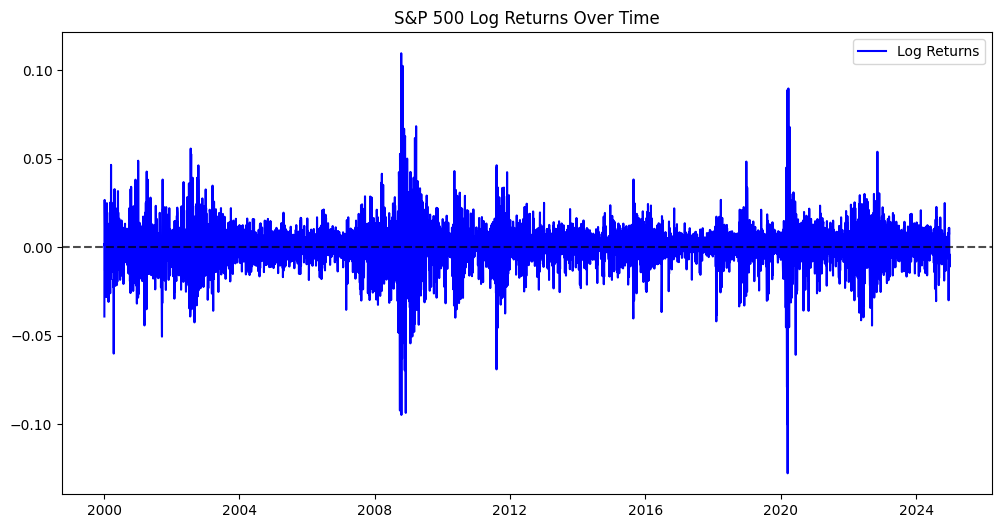

In [ ]:
# 5️⃣ **Visualize Log Returns**
plt.figure(figsize=(12, 6))
plt.plot(sp500.index, sp500["Log_Returns"], label="Log Returns", color="blue")
plt.axhline(0, linestyle="--", color="black", alpha=0.7)
plt.title("S&P 500 Log Returns Over Time")
plt.legend()
plt.show()


In [ ]:
# 6️⃣ **Calculate Hurst Exponent for Bubble Detection**
hurst_exp, _, _ = compute_Hc(sp500["Close"].values, kind="price", simplified=True)
print(f"\n📌 Hurst Exponent: {hurst_exp}")
if hurst_exp > 0.5:
    print("🚨 Possible bubble detected (H > 0.5)")
elif hurst_exp < 0.5:
    print("✅ Mean-reverting behavior (No bubble)")
else:
    print("⚠️ Market follows a random walk")



📌 Hurst Exponent: 0.7175517051184644
🚨 Possible bubble detected (H > 0.5)


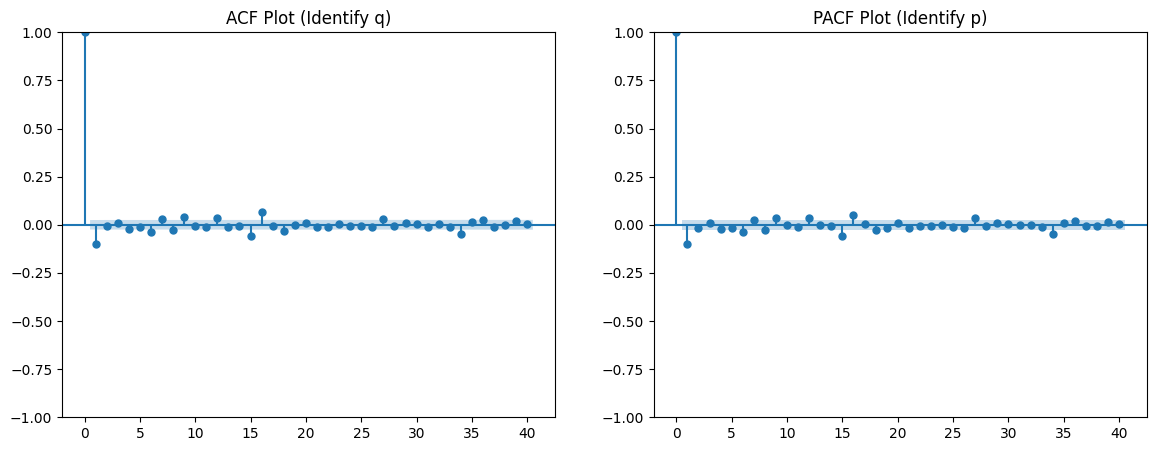

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from arch import arch_model
'''
# Ensure 'Date' column is in datetime format (if not already)
sp500["Date"] = pd.to_datetime(sp500["Date"], format="%d-%m-%Y")

sp500 = sp500.set_index("Date") #Set Date as index
'''
# 1️⃣ Plot ACF and PACF for Log Returns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF Plot (to determine q)
sm.graphics.tsa.plot_acf(sp500["Log_Returns"].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF Plot (Identify q)")

# PACF Plot (to determine p)
sm.graphics.tsa.plot_pacf(sp500["Log_Returns"].dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF Plot (Identify p)")

plt.show()


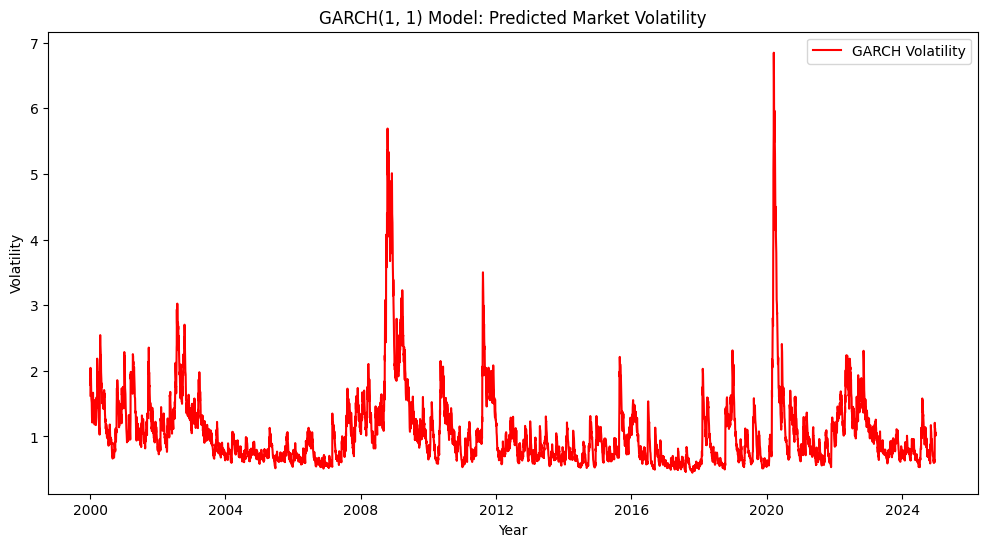

In [ ]:
## 2️⃣ Apply GARCH Model with Selected (p, q)
optimal_p = 1  # Set based on PACF
optimal_q = 1  # Set based on ACF

garch_model = arch_model(sp500["Log_Returns"] * 100, vol="Garch", p=optimal_p, q=optimal_q)
garch_fit = garch_model.fit(disp="off")

# 3️⃣ Store the GARCH volatility predictions
sp500["Volatility"] = garch_fit.conditional_volatility

# 4️⃣ Plot GARCH Volatility Forecast with Years on X-Axis
plt.figure(figsize=(12, 6))
plt.plot(sp500.index, sp500["Volatility"], label="GARCH Volatility", color="red")

# Formatting
plt.xlabel("Year")
plt.ylabel("Volatility")
plt.title(f"GARCH({optimal_p}, {optimal_q}) Model: Predicted Market Volatility")
plt.legend()

plt.show()


📈 RMSE between GARCH predicted variance and actual squared returns: 0.000456


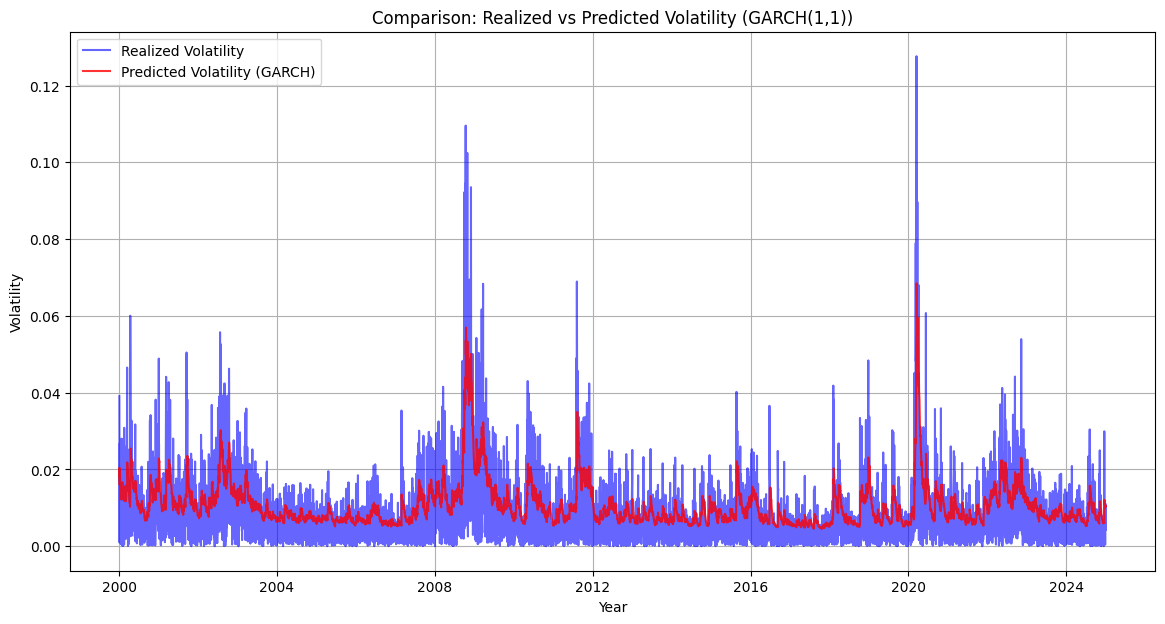

In [ ]:
# 5️⃣ Calculate RMSE between Predicted Volatility and Realized Volatility

from sklearn.metrics import mean_squared_error
import numpy as np

# Make sure "Date" is the index (only needed if not already set)
# sp500["Date"] = pd.to_datetime(sp500["Date"])
# sp500 = sp500.set_index("Date")

# Predicted volatility from GARCH model
predicted_volatility = sp500["Volatility"] / 100  # Rescaling back

# Actual returns
actual_returns = sp500["Log_Returns"].loc[predicted_volatility.index]

# Realized squared returns (proxy for real volatility)
actual_squared_returns = actual_returns ** 2

# Predicted variance (square of predicted volatility)
predicted_variance = predicted_volatility ** 2

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_squared_returns, predicted_variance))

print(f"📈 RMSE between GARCH predicted variance and actual squared returns: {rmse:.6f}")

# 6️⃣ Plot: Predicted Volatility vs Realized Volatility

plt.figure(figsize=(14, 7))

# Realized volatility (sqrt of squared returns)
plt.plot(actual_squared_returns.index, np.sqrt(actual_squared_returns), label="Realized Volatility", color="blue", alpha=0.6)

# Predicted volatility
plt.plot(predicted_volatility.index, predicted_volatility, label="Predicted Volatility (GARCH)", color="red", alpha=0.8)

# Formatting
plt.xlabel("Year")
plt.ylabel("Volatility")
plt.title(f"Comparison: Realized vs Predicted Volatility (GARCH({optimal_p},{optimal_q}))")
plt.legend()
plt.grid(True)
plt.show()


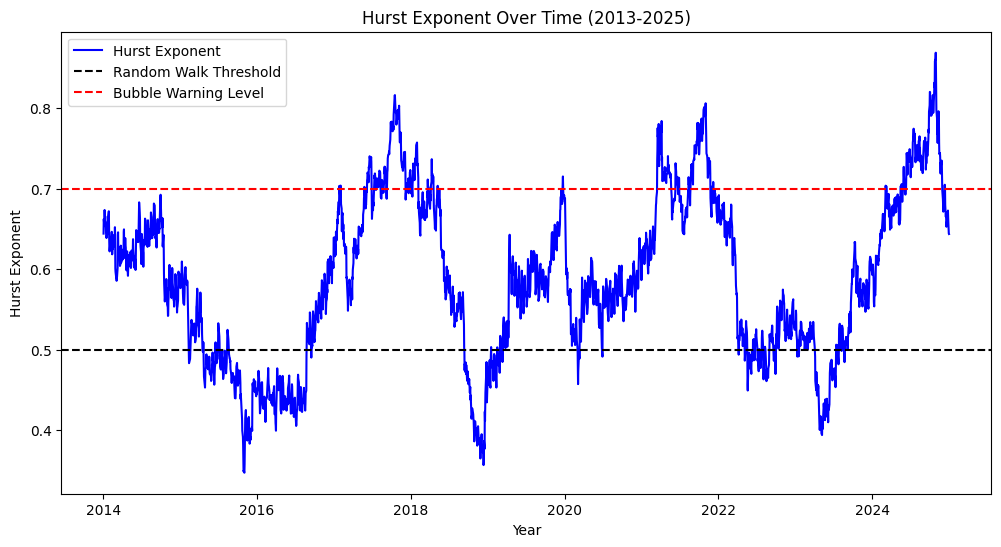

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hurst import compute_Hc

# Assuming `sp500` is your DataFrame containing the S&P 500 data with 'Date' and 'Close' columns.
# Ensure 'Date' is in datetime format
#sp500["Date"] = pd.to_datetime(sp500["Date"], format="%d-%m-%Y")

#sp500 = sp500.set_index("Date")

# Filter data for years 2013 to 2025
sp500_filtered = sp500.loc["2013-01-01":"2025-12-31"]

# Rolling Hurst Exponent Calculation
window_size = 252  # Approx. 1-year rolling window (252 trading days)
hurst_values = []
dates = []

for i in range(len(sp500_filtered) - window_size):
    hurst_exp, _, _ = compute_Hc(sp500_filtered["Close"].values[i : i + window_size], kind="price", simplified=True)
    hurst_values.append(hurst_exp)
    dates.append(sp500_filtered.index[i + window_size])  # Align date with end of window

# Plot Hurst Exponent over time
plt.figure(figsize=(12, 6))
plt.plot(dates, hurst_values, color="blue", label="Hurst Exponent")
plt.axhline(0.5, color="black", linestyle="--", label="Random Walk Threshold")
plt.axhline(0.7, color="red", linestyle="--", label="Bubble Warning Level")
plt.title("Hurst Exponent Over Time (2013-2025)")
plt.xlabel("Year")
plt.ylabel("Hurst Exponent")
plt.legend()
plt.show()


In [ ]:
# Assume sp500 DataFrame is already loaded and indexed by Date
# Add lagged returns and rolling features
for lag in range(1, 6):
    sp500[f'Lag_{lag}'] = sp500['Log_Returns'].shift(lag)
sp500['Rolling_Mean_5'] = sp500['Log_Returns'].rolling(window=5).mean()
sp500['Rolling_Std_5'] = sp500['Log_Returns'].rolling(window=5).std()
sp500.dropna(inplace=True)


In [ ]:
# Use 80% for training, 20% for testing (no shuffling)
train_size = int(len(sp500) * 0.8)
train = sp500.iloc[:train_size]
test = sp500.iloc[train_size:]

X_train = train.drop(['Log_Returns', 'Volatility', 'Close'], axis=1)
y_train = train['Log_Returns']
X_test = test.drop(['Log_Returns', 'Volatility', 'Close'], axis=1)
y_test = test['Log_Returns']


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid

# Hyperparameter grid
param_grid = {
    'n_estimators': [300],
    'max_depth': [5, 10],
   'max_features': ['sqrt', 'log2', 0.8],
    'random_state': [42]
}
'''
param_grid = {
    'n_estimators': [500, 1000],  # Increased tree count
    'max_depth': [None, 15, 20],  # Deeper trees
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 0.6],
    'bootstrap': [True],
    'random_state': [42]
}
'''

best_score = -np.inf
for params in ParameterGrid(param_grid):
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = r2_score(y_test, preds)
    if score > best_score:
        best_score = score
        best_rf_model = model
        best_rf_params = params
        best_rf_preds = preds

rf_mse = mean_squared_error(y_test, best_rf_preds)
rf_mae = mean_absolute_error(y_test, best_rf_preds)
rf_r2 = r2_score(y_test, best_rf_preds)


In [ ]:
import xgboost as xgb

# Hyperparameter grid
xgb_param_grid = {
    'n_estimators': [200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'random_state': [42]
}

best_score = -np.inf
for params in ParameterGrid(xgb_param_grid):
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = r2_score(y_test, preds)
    if score > best_score:
        best_score = score
        best_xgb_model = model
        best_xgb_params = params
        best_xgb_preds = preds

xgb_mse = mean_squared_error(y_test, best_xgb_preds)
xgb_mae = mean_absolute_error(y_test, best_xgb_preds)
xgb_r2 = r2_score(y_test, best_xgb_preds)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Prepare data for LSTM (reshape to [samples, timesteps, features])
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_sequences(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i+time_steps)])
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 5
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

# Hyperparameter values based on literature[4]
lstm_units = 50
dropout_rate = 0.2
batch_size = 32
epochs = 30
learning_rate = 0.001

model = Sequential([
    LSTM(lstm_units, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=False),
    Dropout(dropout_rate),
    Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)

lstm_preds = model.predict(X_test_seq).flatten()
lstm_mse = mean_squared_error(y_test_seq, lstm_preds)
lstm_mae = mean_absolute_error(y_test_seq, lstm_preds)
lstm_r2 = r2_score(y_test_seq, lstm_preds)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
# Updated Classification Metrics Calculation
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_direction(series):
    """Convert continuous returns to directional labels (-1, 0, 1)"""
    if isinstance(series, np.ndarray):
        return np.sign(series)
    return np.sign(series.fillna(0))  # For pandas Series

def calculate_classification_metrics(y_true, predictions_dict):
    results = {}
    y_true_dir = get_direction(y_true)

    for model_name, y_pred in predictions_dict.items():
        y_pred_dir = get_direction(y_pred)

        # Remove zeros (neutral predictions) for clean binary classification
        mask = (y_true_dir != 0) & (y_pred_dir != 0)
        y_true_clean = y_true_dir[mask]
        y_pred_clean = y_pred_dir[mask]

        # Convert to binary classification (up=1, down=0)
        y_true_binary = (y_true_clean > 0).astype(int)
        y_pred_binary = (y_pred_clean > 0).astype(int)

        # Calculate metrics
        results[model_name] = {
            'Accuracy': accuracy_score(y_true_binary, y_pred_binary),
            'Precision': precision_score(y_true_binary, y_pred_binary),
            'Recall': recall_score(y_true_binary, y_pred_binary),
            'F1 Score': f1_score(y_true_binary, y_pred_binary),
            'MSE': mean_squared_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2 Score': r2_score(y_true, y_pred)
        }

    return results

# Prepare predictions properly (convert to arrays)
predictions = {
    'Random Forest': best_rf_preds[time_steps:],
    'XGBoost': best_xgb_preds[time_steps:],
    'LSTM': lstm_preds
}

# Convert y_test_seq to array if needed
if isinstance(y_test_seq, pd.Series):
    y_test_seq = y_test_seq.values

# Calculate metrics
metrics_results = calculate_classification_metrics(y_test_seq, predictions)

# Create formatted table with color gradient
def color_negative_red(val):
    color = 'red' if val < 0 else 'green' if val > 0.75 else 'black'
    return f'color: {color}'

styled_table = pd.DataFrame.from_dict(metrics_results, orient='index').style\
    .format({
        'Accuracy': '{:.2%}',
        'Precision': '{:.2%}',
        'Recall': '{:.2%}',
        'F1 Score': '{:.2%}',
        'MSE': '{:.6f}',
        'MAE': '{:.6f}',
        'R2 Score': '{:.4f}'
    })\
    .background_gradient(subset=['Accuracy', 'Precision', 'Recall', 'F1 Score'], cmap='YlGn')\
    .set_caption("Model Performance Comparison")\
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '12pt'), ('min-width', '100px')]},
        {'selector': 'td', 'props': [('padding', '8px'), ('text-align', 'center')]},
        {'selector': 'caption', 'props': [('font-size', '14pt'), ('margin-bottom', '10px')]}
    ])

styled_table


,Accuracy,Precision,Recall,F1 Score,MSE,MAE,R2 Score
Random Forest,74.44%,71.67%,86.61%,78.44%,0.000104,0.006563,0.4315
XGBoost,89.30%,87.15%,93.90%,90.40%,0.000049,0.004107,0.7311
LSTM,53.67%,53.67%,100.00%,69.85%,0.000263,0.011810,-0.4386


In [ ]:
import matplotlib.dates as mdates


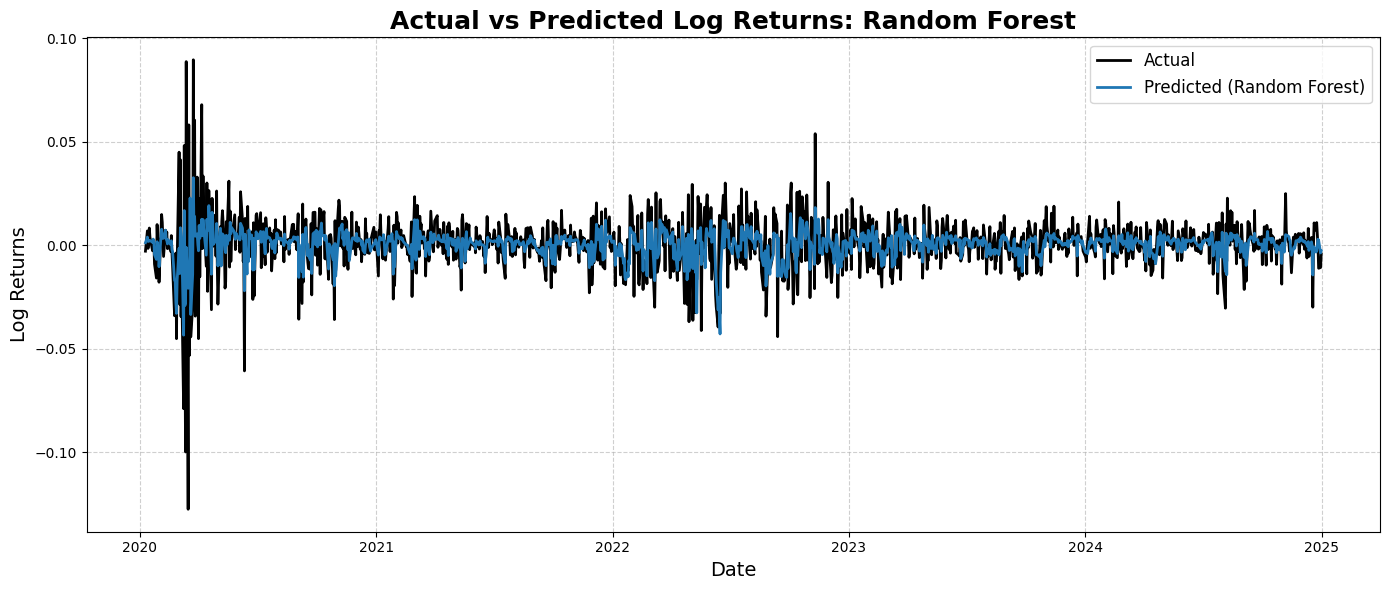

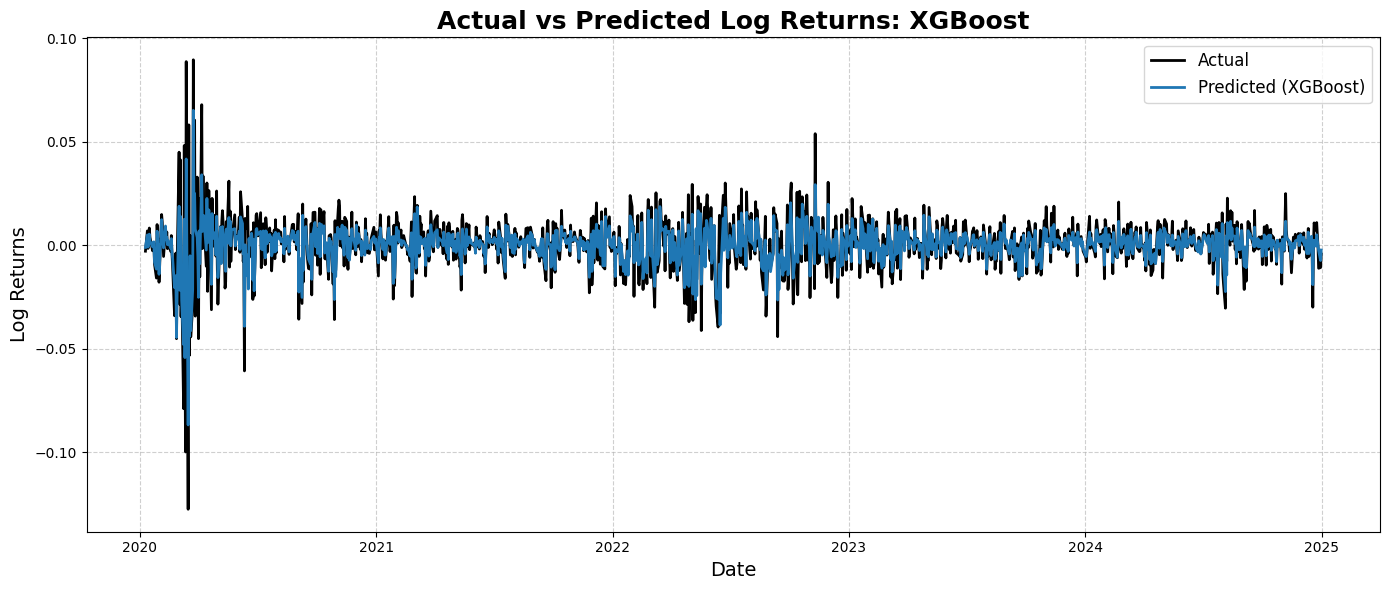

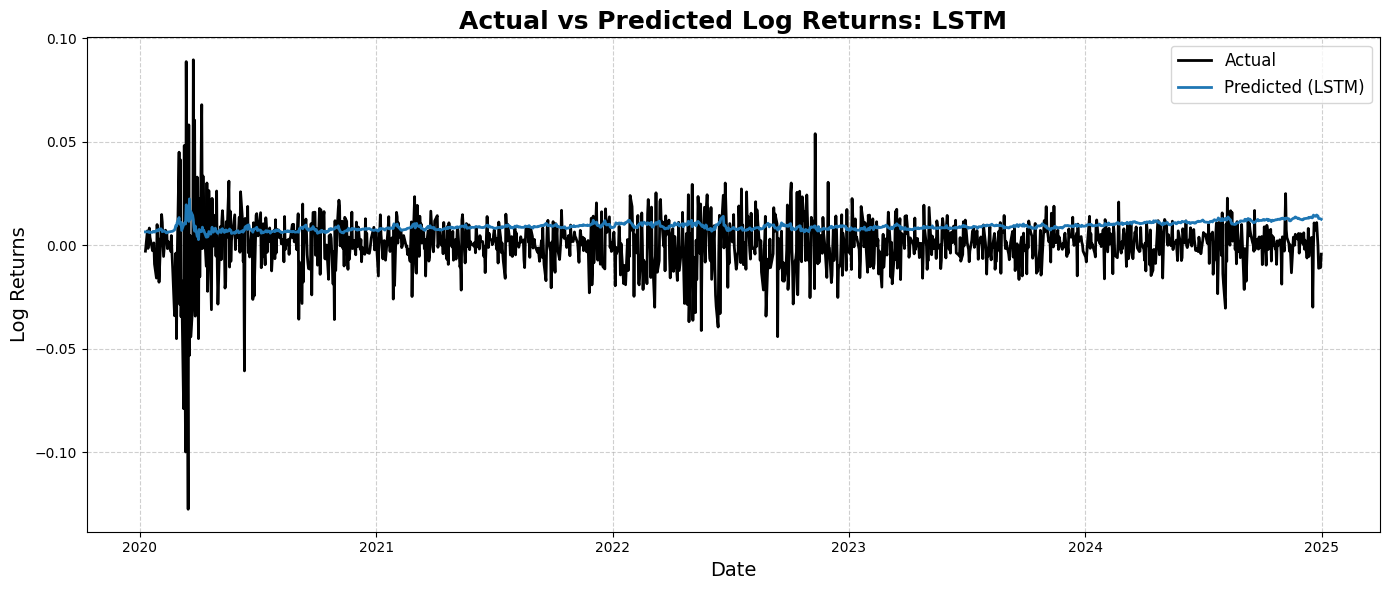

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# If your y_test_seq is a numpy array, convert dates to match its length
dates = pd.to_datetime(y_test.index[time_steps:])

# Define a dictionary for easy looping
model_preds = {
    "Random Forest": best_rf_preds[time_steps:],
    "XGBoost": best_xgb_preds[time_steps:],
    "LSTM": lstm_preds
}

# Plot for each model
for model_name, preds in model_preds.items():
    plt.figure(figsize=(14, 6))
    plt.plot(dates, y_test_seq, label='Actual', color='black', linewidth=2)
    plt.plot(dates, preds, label=f'Predicted ({model_name})', linewidth=2)
    plt.title(f'Actual vs Predicted Log Returns: {model_name}', fontsize=18, fontweight='bold')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Log Returns', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
